In [ ]:
pip install trueskill

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for trueskill: filename=trueskill-0.4.5-py3-none-any.whl size=18046 sha256=9bf256c61a5a4216f62801cc04bc40451a7bc1a1ee74f4afdf945b59425ae498
  Stored in directory: /root/.cache/pip/wheels/bf/cb/b7/441dde3542ccda9474afc6b53b81da197b0867e56e0dae7e09
Successfully built trueskill


In [ ]:
pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Importing the necessary libraries
#Pandas for data manipulation
#Trueskill to apply the rating system to the NBA season
#Matplotlib for plotting graphs
import pandas as pd
import trueskill
import matplotlib.pyplot as plt

In [ ]:
#Importation of data from https://www.basketball-reference.com/leagues/NBA_2019_games.html
#The data was only available per month, so they had to be imported individually
url_oct = 'https://docs.google.com/spreadsheets/d/1OiHwp8h1mctIMdv7WE_3HTrhL4DEaLYmvCbmubQ-qwA/export?format=csv'
url_nov = 'https://docs.google.com/spreadsheets/d/1MzuK_YZrSgrkqutaVhrpk-kjue3okJJ7sjrvHZZs83w/export?format=csv'
url_dec = 'https://docs.google.com/spreadsheets/d/1bcrfFCHHWvSyJaUrOtm_FSKvri-1c7QrEgadLefztw4/export?format=csv'
url_jan = 'https://docs.google.com/spreadsheets/d/1CjfrNS9ac99OyXb_KcCHk_PR2dlMd8WgUUMyQIc1XhM/export?format=csv'
url_feb = 'https://docs.google.com/spreadsheets/d/1VntxYro-mpHmVeQySSDAJM-FOxxlTZ4CrI2XpfhuqT8/export?format=csv'
url_mar = 'https://docs.google.com/spreadsheets/d/1-r1dJU224tbkj56AptYrqD8gDntHEDaVDz633lOBoqI/export?format=csv'
url_apr = 'https://docs.google.com/spreadsheets/d/1LNsN7H_Gkpwpk3YGuNp1TaNZMPIe40TsFzM04nfFnWo/export?format=csv'
url_may = 'https://docs.google.com/spreadsheets/d/11Mbby-dbrP36h3k8HoQrnrNL6VI08iiojGgr72TXfBw/export?format=csv'
url_jun = 'https://docs.google.com/spreadsheets/d/1S9e2PMECEYwwmd3NakmK056mbcuifrLmbnCv-0aPXWE/export?format=csv'

octdf = pd.read_csv(url_oct)
novdf = pd.read_csv(url_nov)
decdf = pd.read_csv(url_dec)
jandf = pd.read_csv(url_jan)
febdf = pd.read_csv(url_feb)
mardf = pd.read_csv(url_mar)
aprdf = pd.read_csv(url_apr)
maydf = pd.read_csv(url_may)
jundf = pd.read_csv(url_jun)

In [ ]:
#The merging of all the dataframes into one big dataframe
monthdf = [octdf, novdf, decdf, jandf, febdf, mardf, aprdf, maydf, jundf]
gamedf = pd.concat(monthdf, ignore_index=True, sort=False)
gamedf.drop_duplicates(keep='first')
gamedf.head()

,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Arena,Notes
0,"Tue, Oct 16, 2018",8:00p,Philadelphia 76ers,87,Boston Celtics,105,Box Score,NaN,"18,624",TD Garden,NaN
1,"Tue, Oct 16, 2018",10:30p,Oklahoma City Thunder,100,Golden State Warriors,108,Box Score,NaN,"19,596",Oracle Arena,NaN
2,"Wed, Oct 17, 2018",7:00p,Milwaukee Bucks,113,Charlotte Hornets,112,Box Score,NaN,"17,889",Spectrum Center,NaN
3,"Wed, Oct 17, 2018",7:00p,Brooklyn Nets,100,Detroit Pistons,103,Box Score,NaN,"20,332",Little Caesars Arena,NaN
4,"Wed, Oct 17, 2018",7:00p,Memphis Grizzlies,83,Indiana Pacers,111,Box Score,NaN,"17,923",Bankers Life Fieldhouse,NaN


In [ ]:
#Setting the trueskill default value for draws to 0, since there is no such things as draws in Basketball as they go to OT
#The rest of the values are left at default values
ts = trueskill.TrueSkill(draw_probability = 0)
ts

trueskill.TrueSkill(mu=25.000, sigma=8.333, beta=4.167, tau=0.083, draw_probability=0.0%)

In [ ]:
#To get a list of all the unique teams
def get_unique_teams():
    teams = []
    for i in gamedf['Visitor/Neutral']:
        if i not in teams:
            teams.append(i)
    return teams
print(len(get_unique_teams()))  #To verify that there are indeed 30 teams on the list

#Getting list of base ratings --> same rating for each team (using the trueskill rating generating function)
def get_default_ratings():
    ratings = []
    for i in get_unique_teams():
        ratings.append(ts.Rating())
    return ratings

30


In [ ]:
#Creating a dataframe from the base rating list and matching them with team names (to be used later when updating and comparing ratings)
ratingdf = pd.DataFrame(get_unique_teams(), columns = {'Team'})
ratingdf['Rating'] = get_default_ratings()
ratingdf = ratingdf.set_index('Team')
ratingdf.head()

,Rating
Team,
Philadelphia 76ers,"trueskill.Rating(mu=25.000, sigma=8.333)"
Oklahoma City Thunder,"trueskill.Rating(mu=25.000, sigma=8.333)"
Milwaukee Bucks,"trueskill.Rating(mu=25.000, sigma=8.333)"
Brooklyn Nets,"trueskill.Rating(mu=25.000, sigma=8.333)"
Memphis Grizzlies,"trueskill.Rating(mu=25.000, sigma=8.333)"


In [ ]:
#Renaming and dropping columns to allow for a more concise and conherent dataframe
gamedf = gamedf.rename(columns = {'PTS' : 'PTS_A', 'PTS.1' : 'PTS_H'})
gamedf = gamedf.drop(['Start (ET)', 'Unnamed: 6', 'Unnamed: 7', 'Attend.', 'Arena', 'Notes'], axis = 1)

In [ ]:
#Making a new column which consists of 1s and 0s, 1 meaning the home team won, 0 meaning they lost
#This is done through the comparison of their points
Home_win = []
for i, row in gamedf.iterrows():
    if row['PTS_H'] > row['PTS_A']:
        Home_win.append(1)
    else:
        Home_win.append(0)
gamedf['Win_H'] = Home_win

In [ ]:
#Uses the trueskill module that produces a new rating based on the outcome of the match
#(used to update the ratings)
def new_ratings(winner_rating, loser_rating):
    new_r_w, new_r_l = (trueskill.rate_1vs1(winner_rating, loser_rating))
    return new_r_w, new_r_l

In [ ]:
#Breaks when playoffs begins
#Assigns the winners/losers to variables and finding the rating of the winners/losers
#The ratings are then plugged in to new_ratings() and are updated in the dataframe
def get_winners():
    for i, r in gamedf.iterrows():
        if r['Date'] == 'Sat, Apr 13, 2019':
            break
        if r['Win_H'] == 1:
            w = r['Home/Neutral']
            l = r['Visitor/Neutral']
        else:
            w = r['Visitor/Neutral']
            l = r['Home/Neutral']
        for p,x in ratingdf.iterrows():
            if p == w:
                old_wr = x['Rating']
            elif p == l:
                old_lr = x['Rating']
        new_wr, new_lr = new_ratings(old_wr, old_lr)
        for q,t in ratingdf.iterrows():
            if q == w:
                t['Rating'] = new_wr
            if q == l:
                t['Rating'] = new_lr
get_winners()

In [ ]:
ratingdf.head()

,Rating
Team,
Philadelphia 76ers,"trueskill.Rating(mu=26.982, sigma=0.980)"
Oklahoma City Thunder,"trueskill.Rating(mu=26.717, sigma=0.957)"
Milwaukee Bucks,"trueskill.Rating(mu=28.846, sigma=1.017)"
Brooklyn Nets,"trueskill.Rating(mu=25.411, sigma=0.976)"
Memphis Grizzlies,"trueskill.Rating(mu=23.634, sigma=0.953)"


In [ ]:
#Mu is representative of 'skill' and changes depending on whether the team wins or loses
#Sigma is a value that decreases as the number of games played increases and dictates 'accuracy' of the 'skill' level
#Mu and Sigma values are extracted from the trueskill format and made into individual columns
#Although Sigma is not explored in this project, it is a very interesting thing to explore in the future
#The hashed out part at the bottom is another, much less elegant, way of extracting mu and sigma.
mu = []
sigma = []
for i,r in ratingdf.iterrows():
    x = r['Rating']
    mu.append(x.mu)
    y = r['Rating']
    sigma.append(y.sigma)
ratingdf['mu'] = mu
ratingdf['sigma'] = sigma
ratingdf.sort_values(by = ['mu'], ascending = False).head(16) # The 16 teams going to the NBA playoffs

#ratingdf = ratingdf.astype(str)
#ratingdf[['Mu', 'Sigma']] = ratingdf.Rating.str.split(expand = True)
#ratingdf[['str', 'mu']] = ratingdf.Mu.str.split('=', expand = True)
#ratingdf[['str1', 'sigma']] = ratingdf.Sigma.str.split('=', expand = True)
#ratingdf = ratingdf.drop(['Rating','str','str1','Sigma','Mu'], axis = 1)
#ratingdf["mu"] = ratingdf["mu"].str.replace(',','').astype(float)
#ratingdf["sigma"] = ratingdf["sigma"].str.replace(')','').astype(float)
#ratingdf.sort_values(by = ['mu'], ascending=False)

,Rating,mu,sigma
Team,,,
Milwaukee Bucks,"trueskill.Rating(mu=28.846, sigma=1.017)",28.845904,1.017089
Golden State Warriors,"trueskill.Rating(mu=28.765, sigma=1.003)",28.764638,1.002922
Toronto Raptors,"trueskill.Rating(mu=28.314, sigma=1.031)",28.314460,1.031273
Houston Rockets,"trueskill.Rating(mu=28.222, sigma=0.976)",28.222105,0.976464
Portland Trail Blazers,"trueskill.Rating(mu=28.174, sigma=0.985)",28.173968,0.984819
Denver Nuggets,"trueskill.Rating(mu=28.041, sigma=0.987)",28.041356,0.986611
Utah Jazz,"trueskill.Rating(mu=27.369, sigma=0.984)",27.369002,0.984264
Philadelphia 76ers,"trueskill.Rating(mu=26.982, sigma=0.980)",26.981916,0.979929
San Antonio Spurs,"trueskill.Rating(mu=26.760, sigma=0.969)",26.759627,0.968654


In [ ]:
#This function gets the teams that play and plugs them in to the second function which compares their ratings to predict a winner
def retrieve_teams():
    winners = []
    for i,r in gamedf.iterrows():
        t1 = r['Home/Neutral']
        t2 = r['Visitor/Neutral']
        w = predicted_winner(t1,t2)
        winners.append(w)
    return winners

def predicted_winner(t1,t2):
    for i,r in ratingdf.iterrows():
        if i == t1:
            t1_rating = r['mu']
        if i == t2:
            t2_rating = r['mu']
    if t1_rating>t2_rating:
        return(t1)
    else:
        return(t2)

In [ ]:
#added column for a predicted winner
gamedf['Pred_W'] = retrieve_teams()
gamedf

,Date,Visitor/Neutral,PTS_A,Home/Neutral,PTS_H,Win_H,Pred_W
0,"Tue, Oct 16, 2018",Philadelphia 76ers,87,Boston Celtics,105,1,Philadelphia 76ers
1,"Tue, Oct 16, 2018",Oklahoma City Thunder,100,Golden State Warriors,108,1,Golden State Warriors
2,"Wed, Oct 17, 2018",Milwaukee Bucks,113,Charlotte Hornets,112,0,Milwaukee Bucks
3,"Wed, Oct 17, 2018",Brooklyn Nets,100,Detroit Pistons,103,1,Brooklyn Nets
4,"Wed, Oct 17, 2018",Memphis Grizzlies,83,Indiana Pacers,111,1,Indiana Pacers
...,...,...,...,...,...,...,...
1307,"Sun, Jun 2, 2019",Golden State Warriors,109,Toronto Raptors,104,0,Golden State Warriors
1308,"Wed, Jun 5, 2019",Toronto Raptors,123,Golden State Warriors,109,0,Golden State Warriors
1309,"Fri, Jun 7, 2019",Toronto Raptors,105,Golden State Warriors,92,0,Golden State Warriors
1310,"Mon, Jun 10, 2019",Golden State Warriors,106,Toronto Raptors,105,0,Golden State Warriors


In [ ]:
# Whenever the predicted winner matches the real winner, a new column displays 1, if not it displays 0
success = []
for i,r in gamedf.iterrows():
    if r['Win_H'] == 1:
        if r['Pred_W'] == r['Home/Neutral']:
            success.append(1)
        else:
            success.append(0)
    if r['Win_H'] == 0:
        if r['Pred_W'] == r['Visitor/Neutral']:
            success.append(1)
        else:
            success.append(0)
gamedf['Successful_pred'] = success

In [ ]:
#Modifying the date column to make it easier to iterate over each month and create a more legible plot using these iterations
gamedf[['Weekday', 'Daymonth', 'year']] = gamedf.Date.str.split(',', expand=True)
gamedf[['Month', 'Day']] = gamedf.Daymonth.str.split(expand=True)
gamedf = gamedf.drop(['Weekday','year', 'Date','Daymonth'], axis = 1)
gamedf

,Visitor/Neutral,PTS_A,Home/Neutral,PTS_H,Win_H,Pred_W,Successful_pred,Month,Day
0,Philadelphia 76ers,87,Boston Celtics,105,1,Philadelphia 76ers,0,Oct,16
1,Oklahoma City Thunder,100,Golden State Warriors,108,1,Golden State Warriors,1,Oct,16
2,Milwaukee Bucks,113,Charlotte Hornets,112,0,Milwaukee Bucks,1,Oct,17
3,Brooklyn Nets,100,Detroit Pistons,103,1,Brooklyn Nets,0,Oct,17
4,Memphis Grizzlies,83,Indiana Pacers,111,1,Indiana Pacers,1,Oct,17
...,...,...,...,...,...,...,...,...,...
1307,Golden State Warriors,109,Toronto Raptors,104,0,Golden State Warriors,1,Jun,2
1308,Toronto Raptors,123,Golden State Warriors,109,0,Golden State Warriors,0,Jun,5
1309,Toronto Raptors,105,Golden State Warriors,92,0,Golden State Warriors,0,Jun,7
1310,Golden State Warriors,106,Toronto Raptors,105,0,Golden State Warriors,1,Jun,10


In [ ]:
# gets all the months
def get_months():
    months = []
    for i,r in gamedf.iterrows():
        if r['Month'] == 'May': #Playoffs start in April
            break
        if r['Month'] not in months:
            months.append(r['Month'])
    return months

def get_monthly_success():
    month = get_months()
    success = []
    for i in month:
        sum = 0
        counter = 0
        for p,r in gamedf.iterrows():
            if r['Month'] == 'Apr' and r['Day'] == 13:
              break
            if r['Month'] == i:
                sum += r['Successful_pred']
                counter +=1
        success.append((sum/counter)*100)
    return success
get_months()

['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']

The average success rate of the predictions over the 2018-2019 NBA season is 67% over the span of 7 months


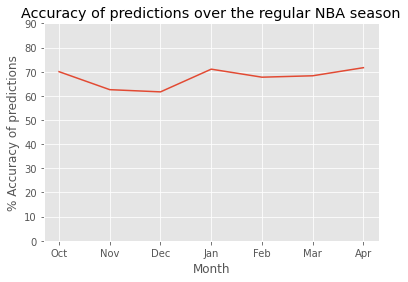

In [ ]:
def plot():
    plt.style.use('ggplot')
    temp = get_months()
    month_number = []
    counter = 0
    for i in temp:
        counter +=1
        month_number.append(counter)
    x = month_number
    y = get_monthly_success()
    plt.plot(x,y)
    x_label = temp
    x_ticks = month_number
    plt.xticks(ticks = x_ticks, labels = x_label)
    plt.xlabel('Month')
    plt.yticks(ticks = range(0,100,10))
    plt.ylabel('% Accuracy of predictions')
    plt.title('Accuracy of predictions over the regular NBA season')
plot()

def get_avg_success():
    x = get_monthly_success()
    counter = 0
    sum = 0
    numb_month = []
    for i in get_months():
      counter += 1
    for i in x:
      sum += i
    avg = int(sum/counter)
    print(f'The average success rate of the predictions over the 2018-2019 NBA season is {avg}% over the span of {counter} months')
get_avg_success()

Conclusion:



---




  The trueskill library is a system created by microsoft for Xbox lives in games such as Halo 2 as an alternative to the ELO system. It ranks the teams through creating a gaussian distribution reflecting the results of the player, in this case teams. The system uses bayesian inference method of statistical inference, which is in layman's terms, a calculation of probability of something happening given a condition. In this project, I explored how this system would perform when applied to the NBA. When tested, the accuracy of the predictions of the regular season games yields an average of 67%, which although is not high, is can still accurately predict 2/3 games. A surprising thing to note is that the month of October is expected to have a lower prediction accuracy, which it did not, and will change the most when running the code, due to the ratings of all the teams being the same at the beginning of the season, therefore the ratings are still taking time to become a more accurate representation of the teams. Although the project was only applied to one season of the NBA, to validate the consistency of the predictions, more/different seasons can be applied.
